In [1]:
import os
import tensorflow as tf
from tensorflow import keras
import random
import numpy as np
import matplotlib.pyplot as plt


from keras import layers, Sequential
from keras.layers import Input, Add, Dense, Activation, ZeroPadding1D, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences


import pandas as pd
from scipy.signal import butter, lfilter
from scipy import stats
from scipy.io import loadmat

#import heartpy as hp

from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


import seaborn as sns


import math
import random
import zipfile  
import io
from PIL import Image

In [2]:
SEED = 4224
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [3]:
from google.colab import drive
drive.mount('/content/drive')
cwd = '/content/drive/My Drive/FinalAssignment'
os.chdir(cwd)
dataset_folder = os.path.join(cwd,'training_set_dir')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
def load_data(sample_prefix, input_dir):    # everything is returned as a numpy array which is easier to manipulate
  label_filepath = os.path.join(input_dir, sample_prefix + '_ann.mat')
  peak_filepath = os.path.join(input_dir, sample_prefix + '_rpk.mat')
  signal_filepath = os.path.join(input_dir, sample_prefix + '.mat')
  if os.path.isfile(label_filepath):
    mat_file = loadmat(label_filepath)
    label = np.asarray(mat_file['labels'])
  if os.path.isfile(peak_filepath):
    mat_file = loadmat(peak_filepath)
    peak = np.asarray(mat_file['rpeaks'])
  if os.path.isfile(signal_filepath):
    mat_file = loadmat(signal_filepath)
    signal = np.asarray(mat_file['ecg'] )

  return label, peak, signal

  
labels = list()             # labels 
ids = list()                # Id of samples 
rpeaks = list()             # detected peaks of the signal 
ecg_signals = list()        # .mat ecg signal 
frequencies = list()        # sample frequency of the ecg signal 


for f in os.listdir(dataset_folder):
  if f.lower().endswith('.mat'):
    id = f[:4]
    if id not in ids:
      ids.append(id)
      sample_prefix = f[:8]
      label, peak, signal = load_data(sample_prefix, dataset_folder)
      labels.append(label)
      rpeaks.append(peak)
      ecg_signals.append(signal)
      frequencies.append(int(sample_prefix[5:]))

print(len(rpeaks))
print(len(rpeaks[0]))

105
2851


In [5]:
cols = ["sigId","ecg_lead_1","ecg_lead_2","peaks","frequencies","labels"]

# ecg signals is 105 rows [,,,,,]

first_lead_signals = []
second_lead_signals = []

for signal in ecg_signals:
    first_lead_signals.append(signal[:,0].tolist())    # converting the array to list as list of array is deprecated 
    second_lead_signals.append(signal[:,1].tolist())

df = pd.DataFrame(data =[ids,first_lead_signals,second_lead_signals,rpeaks,frequencies,labels]).T
df.columns = cols
df

,sigId,ecg_lead_1,ecg_lead_2,peaks,frequencies,labels
0,S001,"[0.0, 0.04, 0.03, 0.0, 0.03, 0.09, 0.18, 0.14,...","[0.08, 0.07, 0.1, 0.06, 0.06, 0.03, 0.1, 0.21,...","[[29], [110], [191], [272], [353], [433], [514...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
1,S002,"[-0.035, -0.045, -0.025, -0.035, -0.045, -0.05...","[-0.095, -0.105, -0.095, -0.095, -0.115, -0.09...","[[48], [153], [243], [352], [440], [547], [636...",128,"[N, N, N, N, S, N, S, N, S, N, S, N, S, N, S, ..."
2,S003,"[-0.56, -0.56, -0.55, -0.47, -0.53, -0.47, -0....","[0.43, 0.56, 0.6, 0.41, 0.54, 0.48, 0.56, 0.46...","[[91], [209], [326], [394], [537], [653], [745...",128,"[N, N, N, S, N, N, S, N, N, S, N, N, N, N, N, ..."
3,S004,"[-0.46, -0.49, -0.52, -0.58, -0.62, -0.69, -0....","[0.56, 0.61, 0.66, 0.66, 0.63, 0.66, 0.59, 0.5...","[[98], [223], [349], [474], [599], [726], [853...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
4,S005,"[-0.27, -0.17, -0.13, -0.23, -0.18, -0.23, -0....","[-0.02, -0.04, -0.01, -0.01, -0.02, -0.06, 0.0...","[[27], [127], [225], [324], [423], [523], [623...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
...,...,...,...,...,...,...
100,S114,"[-0.22, -0.225, -0.23, -0.22, -0.185, -0.155, ...","[-0.86, -0.905, -0.94, -0.975, -1.0, -1.025, -...","[[155], [383], [611], [835], [1053], [1275], [...",250,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
101,S115,"[0.385, 0.35, 0.31, 0.285, 0.265, 0.25, 0.225,...","[0.515, 0.45, 0.38, 0.33, 0.3, 0.28, 0.25, 0.2...","[[215], [437], [667], [823], [1119], [1349], [...",250,"[N, N, N, V, N, N, N, V, N, N, N, N, N, N, N, ..."
102,S116,"[-0.12, -0.12, -0.12, -0.125, -0.12, -0.115, -...","[-0.1, -0.105, -0.11, -0.125, -0.135, -0.13, -...","[[255], [535], [817], [1093], [1377], [1657], ...",250,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
103,S117,"[-0.045, -0.045, -0.045, -0.045, -0.045, -0.04...","[0.175, 0.185, 0.18, 0.175, 0.175, 0.175, 0.17...","[[19], [295], [575], [863], [1151], [1435], [1...",250,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."


In [6]:
def convert_one_vs_rest(label):
  df = np.zeros(len(label))
  for i in range(len(label)):
    if label[i] == 'S':
      df[i] = 1
    elif label[i] == 'V':
      df[i] = 2
  return df

convert_one_vs_rest(labels[3])

array([0., 0., 0., ..., 0., 0., 0.])

In [7]:
# dataset needs to be created because we need to classify beats and not the entire signal 

dataset = dict()
length = 510    # length of each signal, centered at the considered peak
counter = 0


for l,id in enumerate(ids):
    print(f"{l}/{len(ids)}",end='\r')
    for i,peak in enumerate(rpeaks[l]):
        
        dataset[id+"_"+str(i)] = {}
        dataset[id+"_"+str(i)]["first_lead"] = list()
        dataset[id+"_"+str(i)]["second_lead"] = list()

        for s in range(int(peak-length/2),int(peak+length/2)):

            if(s < 0 or s >= len(first_lead_signals[l])):   # padding with 0
                dataset[id+"_"+str(i)]["first_lead"].append(0.) 
                dataset[id+"_"+str(i)]["second_lead"].append(0.) 
            else:
                dataset[id+"_"+str(i)]["first_lead"].append(first_lead_signals[l][s])
                dataset[id+"_"+str(i)]["second_lead"].append(first_lead_signals[l][s])

        dataset[id+"_"+str(i)]["stringLabel"] = labels[l][i]
        dataset[id+"_"+str(i)]["label"] = convert_one_vs_rest(labels[l][i])
    
print("complete")

dataset_df = pd.DataFrame.from_dict(dataset,orient="index") # create the dataframe from dictionary 

dataset_df

complete


,first_lead,second_lead,stringLabel,label
S001_0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",N,[0.0]
S001_1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",N,[0.0]
S001_2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",N,[0.0]
S001_3,"[-0.1, -0.14, -0.14, -0.12, -0.13, -0.08, -0.1...","[-0.1, -0.14, -0.14, -0.12, -0.13, -0.08, -0.1...",N,[0.0]
S001_4,"[-0.05, -0.08, -0.07, -0.08, -0.05, -0.07, -0....","[-0.05, -0.08, -0.07, -0.08, -0.05, -0.07, -0....",N,[0.0]
...,...,...,...,...
S118_2447,"[0.04, 0.02, 0.005, 0.0, 0.005, 0.005, 0.005, ...","[0.04, 0.02, 0.005, 0.0, 0.005, 0.005, 0.005, ...",N,[0.0]
S118_2448,"[0.005, 0.0, -0.005, -0.015, -0.025, -0.035, -...","[0.005, 0.0, -0.005, -0.015, -0.025, -0.035, -...",N,[0.0]
S118_2449,"[-0.02, -0.035, -0.035, -0.04, -0.05, -0.055, ...","[-0.02, -0.035, -0.035, -0.04, -0.05, -0.055, ...",N,[0.0]
S118_2450,"[-0.075, -0.055, -0.065, -0.085, -0.075, -0.07...","[-0.075, -0.055, -0.065, -0.085, -0.075, -0.07...",N,[0.0]


N: 110848
V: 6107
S: 8045


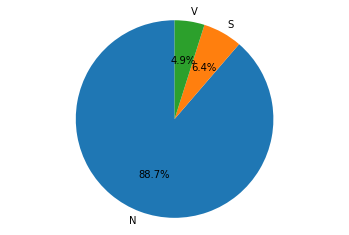

In [8]:
dataset_df = dataset_df[:125000]

ids_n = dataset_df.index[dataset_df['stringLabel'] == 'N'].tolist() 
ids_v = dataset_df.index[dataset_df['stringLabel'] == 'V'].tolist() 
ids_s = dataset_df.index[dataset_df['stringLabel'] == 'S'].tolist() 

print(f"N: {len(ids_n)}")
print(f"V: {len(ids_v)}")
print(f"S: {len(ids_s)}")

classes = ["N","S","V"]
counts = [len(ids_n),len(ids_s),len(ids_v)]

fig1, ax1 = plt.subplots()
ax1.pie(counts, explode=None, labels=classes, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.set_facecolor("white")
plt.show()

N: 110848
V: 6107
S: 8045


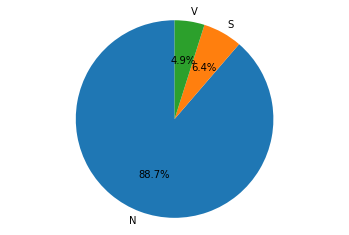

In [9]:
ids_n = dataset_df.index[dataset_df['label'] == 0].tolist() 
ids_v = dataset_df.index[dataset_df['label'] == 2].tolist() 
ids_s = dataset_df.index[dataset_df['label'] == 1].tolist() 

print(f"N: {len(ids_n)}")
print(f"V: {len(ids_v)}")
print(f"S: {len(ids_s)}")

classes = ["N","S","V"]
counts = [len(ids_n),len(ids_s),len(ids_v)]

fig1, ax1 = plt.subplots()
ax1.pie(counts, explode=None, labels=classes, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.set_facecolor("white")
plt.show()

In [10]:
from sklearn.model_selection import train_test_split

test_percentage = 0.2

train_val_df, test_df = train_test_split(dataset_df, test_size=test_percentage)

In [11]:
validation_percentage = 0.2

train_df, validation_df = train_test_split(train_val_df, test_size=validation_percentage)

# Training set

x_train_ = train_df[['first_lead','second_lead']].values

x_train_first_lead = list()
x_train_second_lead = list()

for k in x_train_:
  x_train_first_lead.append(np.array(k[0]).astype(np.float32))
  x_train_second_lead.append(np.array(k[1]).astype(np.float32))
x_train_first_lead = np.asarray(x_train_first_lead).astype(np.float32)
x_train_second_lead = np.asarray(x_train_second_lead).astype(np.float32)

x_train = np.zeros((x_train_first_lead.shape[0], x_train_first_lead.shape[1], 2))
x_train[:,:,0] = x_train_first_lead
x_train[:,:,1] = x_train_second_lead

y_train = train_df['label'].values.tolist()
y_train = np.asarray(y_train).astype(np.float32)
y_train[y_train==2] = 1


# Validation set

x_valid_ = validation_df[['first_lead','second_lead']].values

x_valid_first_lead = list()
x_valid_second_lead = list()

for k in x_valid_:
  x_valid_first_lead.append(np.array(k[0]).astype(np.float32))
  x_valid_second_lead.append(np.array(k[1]).astype(np.float32))
x_valid_first_lead = np.asarray(x_valid_first_lead).astype(np.float32)
x_valid_second_lead = np.asarray(x_valid_second_lead).astype(np.float32)

x_valid = np.zeros((x_valid_first_lead.shape[0], x_valid_first_lead.shape[1], 2))
x_valid[:,:,0] = x_valid_first_lead
x_valid[:,:,1] = x_valid_second_lead

y_valid = validation_df['label'].values.tolist()
y_valid = np.asarray(y_valid).astype(np.float32)
y_valid[y_valid==2] = 1

print(f"samples available for training: {len(x_train)}")
print(f"samples available for validation: {len(x_valid)}")

samples available for training: 80000
samples available for validation: 20000


N: 71018
V: 8982


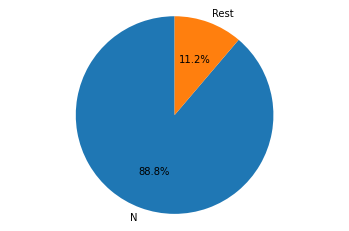

In [13]:
# count classes for training

ids_n = train_df.index[train_df['stringLabel'] == 'N'].tolist() 
ids_rest = train_df.index[train_df['stringLabel'] != 'N'].tolist() 

print(f"N: {len(ids_n)}")
print(f"V: {len(ids_rest)}")

classes = ["N","Rest"]
counts = [len(ids_n),len(ids_rest)]

fig1, ax1 = plt.subplots()
ax1.pie(counts, explode=None, labels=classes, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.set_facecolor("white")
plt.show()

N: 17729
V: 2271


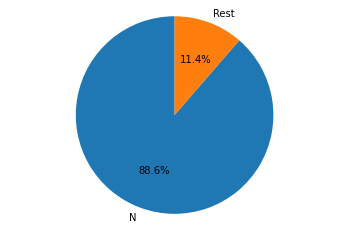

In [14]:
# count classes for validation

ids_n = validation_df.index[validation_df['stringLabel'] == 'N'].tolist() 
ids_rest = validation_df.index[validation_df['stringLabel'] != 'N'].tolist() 

print(f"N: {len(ids_n)}")
print(f"V: {len(ids_rest)}")

classes = ["N","Rest"]
counts = [len(ids_n),len(ids_rest)]

fig1, ax1 = plt.subplots()
ax1.pie(counts, explode=None, labels=classes, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.set_facecolor("white")
plt.show()

In [15]:
def plot_confusion_matrix(y_true, y_pred):
  """
    :param ndarray y_true: contains the ground truth labels in the shape (n_samples,)
    :param ndarray y_pred: contains the predicted labels in the shape (n_samples,)
  """
  con_mat = tf.math.confusion_matrix(labels=np.squeeze(y_true), predictions=np.rint(np.squeeze(y_pred))).numpy()
  con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
  con_mat_df = pd.DataFrame(con_mat_norm,
                  index = classes, 
                  columns = classes)
  figure = plt.figure(figsize=(8, 8))
  sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

# Models

### N vs Rest

In [16]:
timesteps = length
channels_num = 2

input = keras.layers.Input(shape=(timesteps, channels_num))

conv1 = keras.layers.Conv1D(filters=32,kernel_size=25,activation="relu")(input)
maxPool1 = keras.layers.MaxPool1D(pool_size=2)(conv1)
dropout1 = keras.layers.Dropout(0.05)(maxPool1)
conv2 = keras.layers.Conv1D(filters=64,kernel_size=12,activation="relu")(dropout1)
maxPool2 = keras.layers.MaxPool1D(pool_size=2)(conv2)
dropout2 = keras.layers.Dropout(0.1)(maxPool2)
conv3 = keras.layers.Conv1D(filters=128,kernel_size=9,activation="relu")(dropout2)
maxPool3 = keras.layers.MaxPool1D(pool_size=2)(conv3)
dropout3 = keras.layers.Dropout(0.15)(maxPool3)
lstm1 = keras.layers.LSTM(64, return_sequences=True)(dropout3)
lstm2 = keras.layers.LSTM(64, return_sequences=False)(lstm1)
output = keras.layers.Dense(1, activation=tf.nn.sigmoid)(lstm2)
model = keras.models.Model(inputs=input, outputs=output)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 510, 2)]          0         
                                                                 
 conv1d (Conv1D)             (None, 486, 32)           1632      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 243, 32)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 243, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 232, 64)           24640     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 116, 64)          0         
 1D)                                                         

Epoch 1/50
625/625 [==============================] - 43s 47ms/step - loss: 0.2333 - accuracy: 0.9225 - val_loss: 0.1103 - val_accuracy: 0.9622
Epoch 2/50
625/625 [==============================] - 28s 44ms/step - loss: 0.0911 - accuracy: 0.9689 - val_loss: 0.0822 - val_accuracy: 0.9708
Epoch 3/50
625/625 [==============================] - 28s 44ms/step - loss: 0.0714 - accuracy: 0.9747 - val_loss: 0.0630 - val_accuracy: 0.9794
Epoch 4/50
625/625 [==============================] - 28s 44ms/step - loss: 0.0643 - accuracy: 0.9775 - val_loss: 0.0650 - val_accuracy: 0.9766
Epoch 5/50
625/625 [==============================] - 28s 44ms/step - loss: 0.0600 - accuracy: 0.9787 - val_loss: 0.0576 - val_accuracy: 0.9802
Epoch 6/50
625/625 [==============================] - 27s 44ms/step - loss: 0.0560 - accuracy: 0.9803 - val_loss: 0.0583 - val_accuracy: 0.9809
Epoch 7/50
625/625 [==============================] - 28s 44ms/step - loss: 0.0537 - accuracy: 0.9807 - val_loss: 0.0584 - val_accuracy:

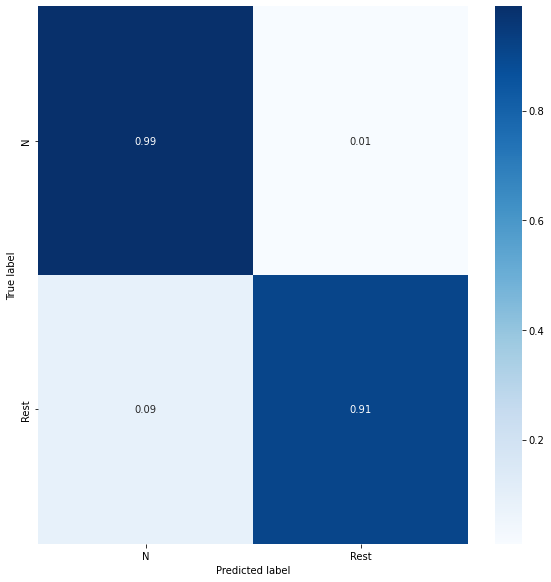

In [17]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,mode="auto")

batch_size = 128
learning_rate = 1e-7
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy'],
    
)

history = model.fit(
    x = x_train,
    y = y_train, 
    batch_size = batch_size,
    steps_per_epoch=len(x_train)/batch_size,
    validation_data=(x_valid, y_valid),
    epochs = 50,
    shuffle = True,
    callbacks=[callback],
).history


y_pred = model.predict(x_valid)

plot_confusion_matrix(y_valid, y_pred)

In [18]:
tf.math.confusion_matrix(labels=np.squeeze(y_valid), predictions=np.rint(np.squeeze(y_pred))).numpy()

array([[17617,   112],
       [  203,  2068]], dtype=int32)

In [19]:
eval = model.evaluate(x=x_valid,y=y_valid,batch_size = 1)

20000/20000 [==============================] - 172s 9ms/step - loss: 0.0490 - accuracy: 0.9843


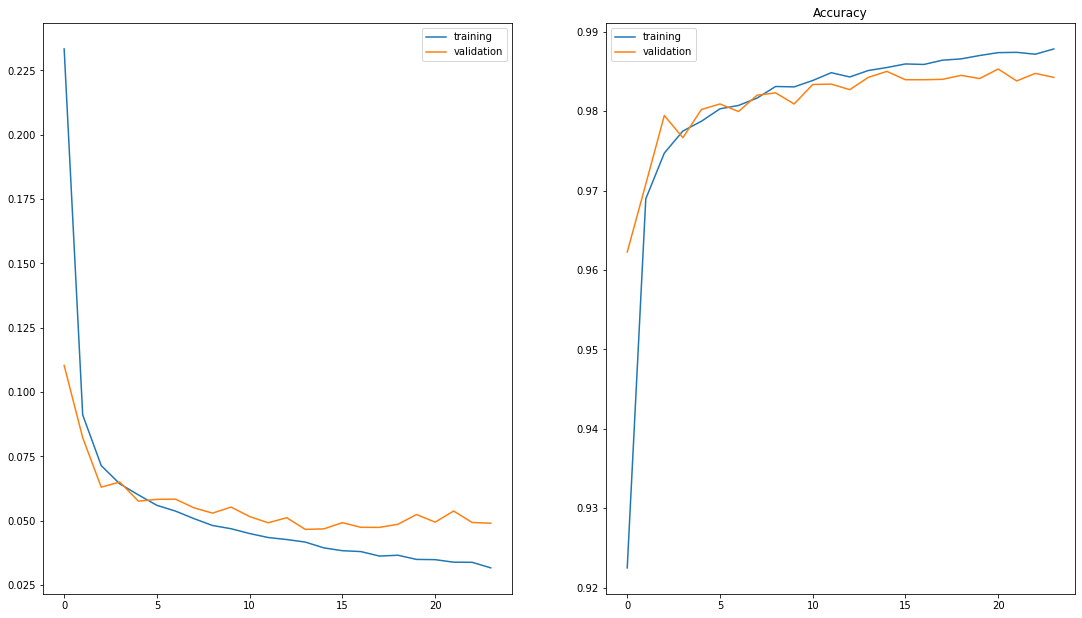

In [20]:
fig,(ax1,ax2) = plt.subplots(1,2)

x = range(len(history['loss']))
# loss
y_train = history['loss']
y_valid = history['val_loss']
ax2.set_title("Loss")
ax1.plot(x,y_train,label="training")
ax1.plot(x,y_valid,label="validation")
ax1.legend()
# accuracy 
y_train = history['accuracy']
y_valid = history['val_accuracy']
ax2.set_title("Accuracy")
ax2.plot(x,y_train,label="training")
ax2.plot(x,y_valid,label="validation")
ax2.legend()

fig.set_size_inches(18.5, 10.5)
plt.show()

### S vs V (discarding N)

In [21]:
x_ = train_val_df[['first_lead','second_lead']].values

x_first_lead = list()
x_second_lead = list()

for k in x_:
  x_first_lead.append(np.array(k[0]).astype(np.float32))
  x_second_lead.append(np.array(k[1]).astype(np.float32))
x_first_lead = np.asarray(x_first_lead).astype(np.float32)
x_second_lead = np.asarray(x_second_lead).astype(np.float32)

x = np.zeros((x_first_lead.shape[0], x_first_lead.shape[1], 2))
x[:,:,0] = x_first_lead
x[:,:,1] = x_second_lead

y = train_val_df['label'].values.tolist()
y = np.asarray(y).astype(np.int)

In [22]:
np.histogram(y)

(array([88747,     0,     0,     0,     0,  6391,     0,     0,     0,
         4862]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]))

In [23]:
# eval = model.evaluate(x=x,y=y,batch_size = 1)

In [24]:
y_red = y[y!=0] # Remove 'N' and consider the rest

len(y_red)

11253

In [25]:
np.histogram(y)

(array([88747,     0,     0,     0,     0,  6391,     0,     0,     0,
         4862]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]))

In [26]:
x_red = x[np.squeeze(y)!=0]
x_red.shape

(11253, 510, 2)

In [27]:
validation_percentage = 0.2

x_red_train, x_red_valid, y_red_train, y_red_valid = train_test_split(x_red, y_red, test_size=validation_percentage)

print(f"samples available for training: {len(x_red_train)}")
print(f"samples available for validation: {len(x_red_valid)}")

samples available for training: 9002
samples available for validation: 2251


S: 5109
V: 3893


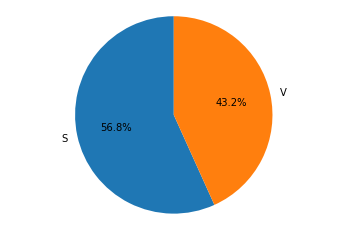

In [28]:
# count classes for training

ids_s = x_red_train[y_red_train == 1].tolist() 
ids_v = x_red_train[y_red_train == 2].tolist() 

print(f"S: {len(ids_s)}")
print(f"V: {len(ids_v)}")

classes = ["S","V"]
counts = [len(ids_s),len(ids_v)]

fig1, ax1 = plt.subplots()
ax1.pie(counts, explode=None, labels=classes, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.set_facecolor("white")
plt.show()

S: 5109
V: 3893


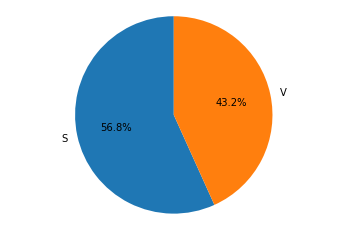

In [29]:
# count classes for validation

ids_s = x_red_train[y_red_train == 1].tolist() 
ids_v = x_red_train[y_red_train == 2].tolist() 

print(f"S: {len(ids_s)}")
print(f"V: {len(ids_v)}")

classes = ["S","V"]
counts = [len(ids_s),len(ids_v)]

fig1, ax1 = plt.subplots()
ax1.pie(counts, explode=None, labels=classes, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.set_facecolor("white")
plt.show()

In [30]:
y_red_train[y_red_train==2] = 3
y_red_valid[y_red_valid==2] = 3

y_red_train[y_red_train==1] = 0
y_red_valid[y_red_valid==1] = 0
y_red_train[y_red_train==3] = 1
y_red_valid[y_red_valid==3] = 1

In [31]:
np.histogram(y_red_train)

(array([5109,    0,    0,    0,    0,    0,    0,    0,    0, 3893]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

In [32]:
timesteps = length
channels_num = 2

input = keras.layers.Input(shape=(timesteps, channels_num))

conv1 = keras.layers.Conv1D(filters=32,kernel_size=25,activation="relu")(input)
maxPool1 = keras.layers.MaxPool1D(pool_size=2)(conv1)
dropout1 = keras.layers.Dropout(0.05)(maxPool1)
conv2 = keras.layers.Conv1D(filters=64,kernel_size=12,activation="relu")(dropout1)
maxPool2 = keras.layers.MaxPool1D(pool_size=2)(conv2)
dropout2 = keras.layers.Dropout(0.1)(maxPool2)
conv3 = keras.layers.Conv1D(filters=128,kernel_size=9,activation="relu")(dropout2)
maxPool3 = keras.layers.MaxPool1D(pool_size=2)(conv3)
dropout3 = keras.layers.Dropout(0.15)(maxPool3)
lstm1 = keras.layers.LSTM(64, return_sequences=True)(dropout3)
lstm2 = keras.layers.LSTM(64, return_sequences=False)(lstm1)
output = keras.layers.Dense(1, activation=tf.nn.sigmoid)(lstm2)
model_red = keras.models.Model(inputs=input, outputs=output)

model_red.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 510, 2)]          0         
                                                                 
 conv1d_3 (Conv1D)           (None, 486, 32)           1632      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 243, 32)          0         
 1D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 243, 32)           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 232, 64)           24640     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 116, 64)          0         
 1D)                                                       

Epoch 1/100
70/70 [==============================] - 9s 70ms/step - loss: 0.5125 - accuracy: 0.7388 - val_loss: 0.3077 - val_accuracy: 0.8676
Epoch 2/100
70/70 [==============================] - 3s 41ms/step - loss: 0.2505 - accuracy: 0.8960 - val_loss: 0.2023 - val_accuracy: 0.9303
Epoch 3/100
70/70 [==============================] - 3s 41ms/step - loss: 0.1796 - accuracy: 0.9368 - val_loss: 0.1840 - val_accuracy: 0.9445
Epoch 4/100
70/70 [==============================] - 3s 41ms/step - loss: 0.1463 - accuracy: 0.9496 - val_loss: 0.1516 - val_accuracy: 0.9498
Epoch 5/100
70/70 [==============================] - 3s 42ms/step - loss: 0.1309 - accuracy: 0.9575 - val_loss: 0.1481 - val_accuracy: 0.9538
Epoch 6/100
70/70 [==============================] - 3s 42ms/step - loss: 0.1159 - accuracy: 0.9619 - val_loss: 0.1259 - val_accuracy: 0.9596
Epoch 7/100
70/70 [==============================] - 3s 42ms/step - loss: 0.1097 - accuracy: 0.9649 - val_loss: 0.1147 - val_accuracy: 0.9600
Epoch 

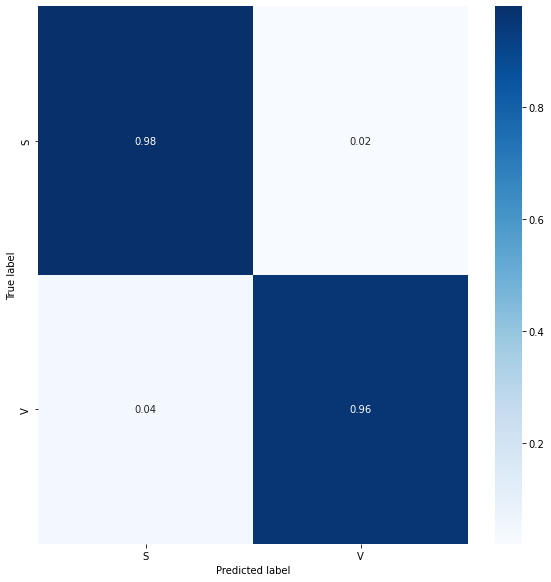

In [33]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,mode="auto")

batch_size = 128
learning_rate = 1e-12
model_red.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy'],
    
)

history2 = model_red.fit(
    x = x_red_train,
    y = y_red_train, 
    batch_size = batch_size,
    steps_per_epoch=len(x_red_train)/batch_size,
    validation_data=(x_red_valid, y_red_valid),
    epochs = 100,
    shuffle = True,
    callbacks=[callback],
).history


y_red_pred = model_red.predict(x_red_valid)

plot_confusion_matrix(y_red_valid, y_red_pred)

In [34]:
tf.math.confusion_matrix(labels=np.squeeze(y_red_valid), predictions=np.rint(np.squeeze(y_red_pred))).numpy()

array([[1256,   26],
       [  42,  927]], dtype=int32)

In [35]:
eval = model_red.evaluate(x=x_red_valid,y=y_red_valid,batch_size = 1)

2251/2251 [==============================] - 21s 9ms/step - loss: 0.0995 - accuracy: 0.9698


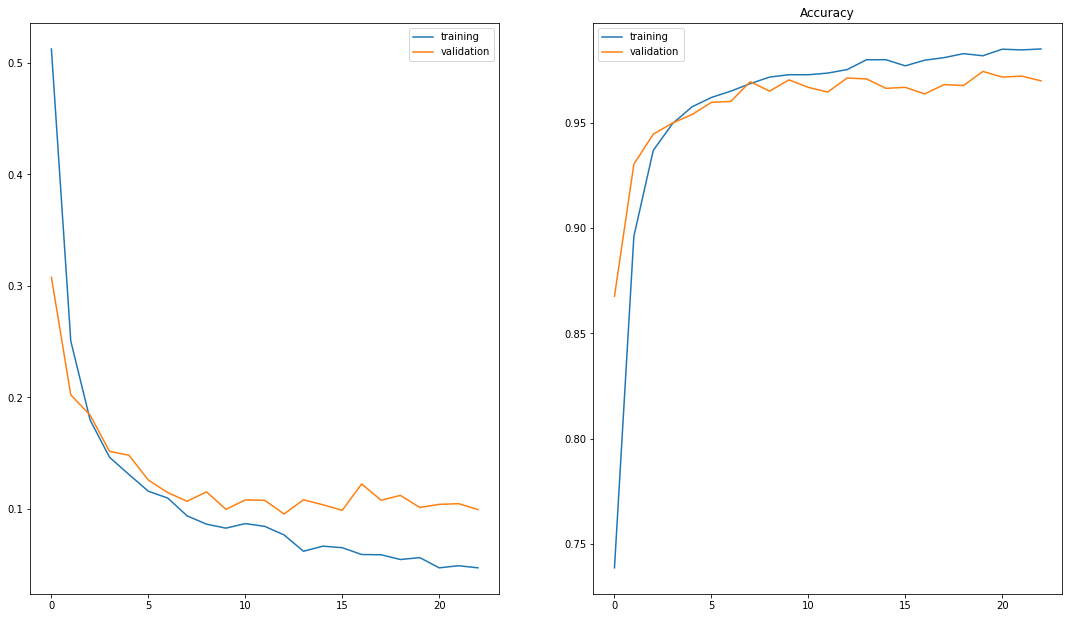

In [36]:
fig,(ax1,ax2) = plt.subplots(1,2)

x = range(len(history2['loss']))
# loss
y_train = history2['loss']
y_valid = history2['val_loss']
ax2.set_title("Loss")
ax1.plot(x,y_train,label="training")
ax1.plot(x,y_valid,label="validation")
ax1.legend()
# accuracy 
y_train = history2['accuracy']
y_valid = history2['val_accuracy']
ax2.set_title("Accuracy")
ax2.plot(x,y_train,label="training")
ax2.plot(x,y_valid,label="validation")
ax2.legend()

fig.set_size_inches(18.5, 10.5)
plt.show()

In [37]:
# Test set

x_test_ = test_df[['first_lead','second_lead']].values

x_test_first_lead = list()
x_test_second_lead = list()

for k in x_test_:
  x_test_first_lead.append(np.array(k[0]).astype(np.float32))
  x_test_second_lead.append(np.array(k[1]).astype(np.float32))
x_test_first_lead = np.asarray(x_test_first_lead).astype(np.float32)
x_test_second_lead = np.asarray(x_test_second_lead).astype(np.float32)

x_test = np.zeros((x_test_first_lead.shape[0], x_test_first_lead.shape[1], 2))
x_test[:,:,0] = x_test_first_lead
x_test[:,:,1] = x_test_second_lead

y_test = test_df['label'].values.tolist()
y_test = np.asarray(y_test).astype(np.float32)

In [38]:
x_test.shape

(25000, 510, 2)

In [39]:
y_test.shape

(25000, 1)

In [40]:
y_test_1 = y_test.copy()
y_test_1[y_test_1==2] = 1

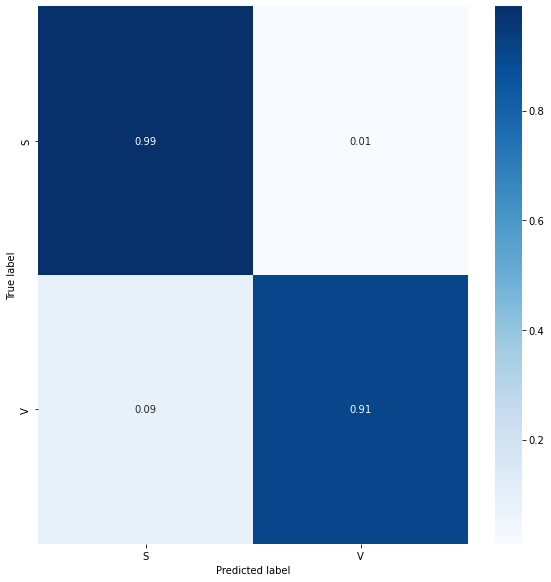

In [41]:
y_test_pred_1 = model.predict(x_test)

plot_confusion_matrix(y_test_1, y_test_pred_1)

In [42]:
tf.math.confusion_matrix(labels=np.squeeze(y_test_1), predictions=np.rint(np.squeeze(y_test_pred_1))).numpy()

array([[21976,   125],
       [  274,  2625]], dtype=int32)

In [43]:
eval_model1 = model.evaluate(x=x_test,y=y_test_1,batch_size = 1)

25000/25000 [==============================] - 214s 9ms/step - loss: 0.0485 - accuracy: 0.9840


In [44]:
y_test_pred_1 = np.rint(np.squeeze(y_test_pred_1))

In [45]:
x_test_2 = x_test[y_test_pred_1!=0]
y_test_2 = y_test[y_test_pred_1!=0]

In [46]:
x_test_2.shape

(2750, 510, 2)

In [47]:
y_test_2.shape

(2750, 1)

In [48]:
y_test_2[y_test_2==2] = 3

y_test_2[y_test_2==1] = 0
y_test_2[y_test_2==3] = 1

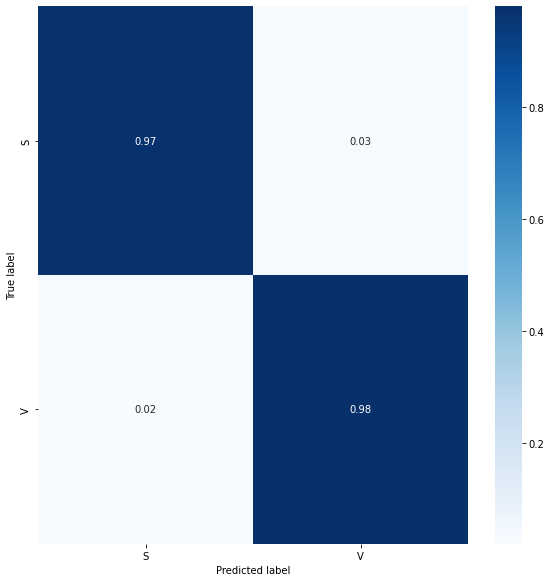

In [49]:
y_test_pred_2 = model_red.predict(x_test_2)

plot_confusion_matrix(y_test_2, y_test_pred_2)

In [50]:
tf.math.confusion_matrix(labels=np.squeeze(y_test_2), predictions=np.rint(np.squeeze(y_test_pred_2))).numpy()

array([[1493,   48],
       [  30, 1179]], dtype=int32)

In [51]:
eval_model2 = model_red.evaluate(x=x_test_2,y=y_test_2,batch_size = 1)

2750/2750 [==============================] - 24s 9ms/step - loss: 0.1064 - accuracy: 0.9716
